# Tutorial ((Text Data Processing))

(Last updated: Jan 29, 2024)[^credit]

[^credit]: Credit: this teaching material is created by [Robert van Straten](https://github.com/robertvanstraten) under the supervision of [Yen-Chia Hsu](https://github.com/yenchiah).

This tutorial will familiarize you with the data science pipeline of processing text data. We will go through the various steps involved in the Natural Language Processing (NLP) pipeline for topic modelling and topic classification, including tokenization, lemmatization, and obtaining word embeddings. We will also build a neural network using PyTorch for multi-class topic classification using the dataset.

The AG's News Topic Classification Dataset contains news articles from four different categories, making it a nice source of text data for NLP tasks. We will guide you through the process of understanding the dataset, implementing various NLP techniques, and building a model for classification.

You can use the following links to jump to the tasks and assignments:
*   [Task 3: Preprocess Text Data](#t3)
    *   [Tokenization](#t3-1)
    *   [Part-of-speech tagging](#t3-2)
    *   [Stemming / Lemmatization](#t3-3)
    *   [Stopword removal](#t3-4)
    *   [Assignment for Task 3](#a3)
*   [Task 4: Another option: spaCy](#t4)
    *   [Assignment for Task 4](#a4)
*   [Task 5: Unsupervised Learning - Topic Modelling](#t5)
    *   [Evaluation](#t5-1)
    *   [Assignment for Task 5](#a5)
*   [Task 6: Word Embeddings](#t6)
    *   [Assignment for Task 6](#a6)
*   [Task 7: Supervised Learning - Topic Classification](#t7)
    *   [Assignment for Task 7 (Optional)](#a7)
*   [Optional Assignment / Takeaways](#a8)

## Scenario

The [AG's News Topic Classification Dataset](https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset) is a collection of over 1 million news articles from more than 2000 news sources. The dataset was created by selecting the 4 largest classes from the original corpus, resulting in 120,000 training samples and 7,600 testing samples. The dataset is provided by the academic community for research purposes in data mining, information retrieval, and other non-commercial activities. We will use it to demonstrate various NLP techniques on real data, and in the end, make 2 models with this data. The files train.csv and test.csv contain all the training and testing samples as comma-separated values with 3 columns: class index, title, and description. Download train.csv and test.csv for the following tasks. 

## Import Packages

We put all the packages that are needed for this tutorial below:

In [1]:
import os
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
import torch
import torch.nn as nn
import torch.optim as optim

from gensim.models import Word2Vec

from nltk.corpus import stopwords, wordnet
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score, confusion_matrix

from tqdm.notebook import tqdm

from wordcloud import WordCloud

from xml.sax import saxutils as su

# Add tqdm functions to pandas.
tqdm.pandas()

## Task Answers

The code block below contains answers for the assignments in this tutorial. **Do not check the answers in the next cell before practicing the tasks.**

In [2]:
def check_answer_df(df_result, df_answer, n=1):
    """
    This function checks if two output dataframes are the same.

    Parameters
    ----------
    df_result : pandas.DataFrame
        The result from the output of a function.
    df_answer: pandas.DataFrame
        The expected output of the function.
    n : int
        The numbering of the test case.
    """
    try:
        assert df_answer.equals(df_result)
        print(f"Test case {n} passed.")
    except Exception:
        print(f"Test case {n} failed.")
        print("Your output is:")
        display(df_result)
        print("Expected output is:")
        display(df_answer)


def check_answer_np(arr_result, arr_answer, n=1):
    """
    This function checks if two output dataframes are the same.

    Parameters
    ----------
    df_result : pandas.DataFrame
        The result from the output of a function.
    df_answer: pandas.DataFrame
        The expected output of the function.
    n : int
        The numbering of the test case.
    """
    try:
        assert np.array_equal(arr_result, arr_answer)
        print(f"Test case {n} passed.")
    except Exception:
        print(f"Test case {n} failed.")
        print("Your output is:")
        print(arr_result)
        print("Expected output is:")
        print(arr_answer)


def answer_tokenize_and_lemmatize(df):
    """
    Tokenize and lemmatize the text in the dataset.

    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe containing at least the text column.

    Returns
    -------
    pandas.DataFrame
        The dataframe with the added tokens column.
    """
    # Copy the dataframe to avoid editing the original one.
    df = df.copy(deep=True)

    # Apply the tokenizer to create the tokens column.
    df["tokens"] = df["text"].progress_apply(word_tokenize)

    # Apply the lemmatizer on every word in the tokens list.
    df["tokens"] = df["tokens"].progress_apply(lambda tokens: [lemmatizer.lemmatize(token, wordnet_pos(tag))
                                                               for token, tag in nltk.pos_tag(tokens)])
    return df



def answer_get_class_distributions(df, token_col="tokens"):
    """
    Generate dataframes with the word distribution for each class in the data.

    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe containing at least the "class" and "tokens" columns.
    token_col: str
        Name of the column that stores the tokens

    Returns
    -------
    dict:
        Dictionary where keys are the class names and values are dataframes with the word distribution
        of each class (the "count" column should have the number of appearances of each word in that class)
    """
    distributions = {}
    class_names = set(df["class"].values)

    # Copy the dataframe to avoid editing the original one.
    df = df.copy(deep=True)
    
    # Filter out non-words
    df[token_col] = df[token_col].apply(lambda tokens: [token for token in tokens if token.isalpha()])

    # Explode the tokens so that every token gets its own row.
    df = df.explode(token_col)

    # Groupby on class and token, get the size of how many rows per item, add that as a column.
    counts = df.groupby(["class", token_col]).size().reset_index(name="count")

    for class_name in class_names:
        distributions[class_name] = counts[counts["class"] == class_name]

    return distributions

def answer_visualize_word_distribution(df, class_name):
    """
    Displays a word cloud given a word distribution.

    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe containing at least the tokens and counts columns with the word distribution in a class.
    class_name: str
        Name of the class.
    """
    # Define dictionary of frequencies
    frequencies = dict(zip(df["tokens"], df["count"]))

    # Generate word cloud from frequencies
    wordcloud = WordCloud(background_color="white", width=1000, height=500, random_state=42).generate_from_frequencies(frequencies)

    # Display image
    plt.axis("off")
    plt.title("Class: " + class_name)
    plt.imshow(wordcloud)
    plt.show()


def answer_most_used_words(df, n_words=5):
    """
    Generate a dataframe with the n_words most used words per class, and their count.

    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe containing at least the class and tokens columns.
    n_words: int
        Number of most used words to include in the dataframe.
    Returns
    -------
    pandas.DataFrame
        The dataframe with n_words rows per class, and an added "count" column.
        The dataframe is sorted in descending order on the count.
    """
    # Sort the values on the class and count, get only the first n_words rows per class.
    df_sorted = df.sort_values("count", ascending=False).head(n=n_words)

    return df_sorted


def answer_remove_stopwords(df):
    """
    Remove stopwords from the tokens.

    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe containing at least the tokens column,
        where the value in each row is a list of tokens.

    Returns
    -------
    pandas.DataFrame
        The dataframe with stopwords removed from the tokens column.
    """
    # Copy the dataframe to avoid editing the original one.
    df = df.copy(deep=True)

    # Using a set for quicker lookups.
    stopwords_set = set(stopwords_list)

    # Filter stopwords from tokens.
    df["tokens"] = df["tokens"].apply(lambda tokens: [token for token in tokens
                                                      if token.lower() not in stopwords_set])

    return df


def answer_spacy_tokens(df):
    """
    Add a column with a list of lemmatized tokens, without stopwords.

    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe containing at least the doc column.

    Returns
    -------
    pandas.DataFrame
        The dataframe with the spacy_tokens column.
    """
    # Copy the dataframe to avoid editing the original one.
    df = df.copy(deep=True)

    df["spacy_tokens"] = df["doc"].apply(lambda tokens: [token.lemma_ for token in tokens
                                                         if not token.is_stop])

    return df


def answer_largest_proportion(arr):
    """
    For every row, get the column number where it has the largest value.

    Parameters
    ----------
    arr : numpy.array
        The array with the amount of topics as the amount of columns
        and the amount of documents as the number of rows.
        Every row should sum up to 1.

    Returns
    -------
    pandas.DataFrame
        The 1-dimensional array containing the label of the topic
        the document has the largest proportion in.
    """
    return np.argmax(arr, axis=1)


def answer_add_padded_tensors(df1, df2):
    """
    Add a tensor column to the dataframes, with every tensor having the same dimensions.

    Parameters
    ----------
    df_train : pandas.DataFrame
        The first dataframe containing at least the tokens or doc column.
    df_test : pandas.DataFrame
        The second dataframe containing at least the tokens or doc column.

    Returns
    -------
    tuple[pandas.DataFrame]
        The dataframes with the added tensor column.
    """
    # Copy the dataframes to avoid editing the originals.
    df1 = df1.copy(deep=True)
    df2 = df2.copy(deep=True)

    # Sample 10% from both datasets.
    df1 = df1.sample(frac=0.1, random_state=42)
    df2 = df2.sample(frac=0.1, random_state=42)

    # Add tensors (option 1: our own model).
    for df in [df1, df2]:
        df["tensor"] = df["tokens"].apply(lambda tokens: np.vstack([w2v_model.wv[token]
                                                                    for token in tokens]))

    # Add tensors (option 2: spaCy tensors).
    for df in [df1, df2]:
        df["tensor"] = df["doc"].apply(lambda doc: doc.tensor)

    # Determine the largest amount of columns.
    largest = max(df1["tensor"].apply(lambda x: x.shape[0]).max(),
                  df2["tensor"].apply(lambda x: x.shape[0]).max())

    # Pad our tensors to that amount.
    for df in [df1, df2]:
        df["tensor"] = df["tensor"].apply(lambda x: np.pad(x, ((0, largest - x.shape[0]), (0, 0))))

    return df1, df2


# Confusion matrix code

# # Compute the confusion matrix
# cm = confusion_matrix(test_labels, test_pred)

# # Plot the confusion matrix using seaborn
# sns.heatmap(cm, annot=True, cmap="Blues", fmt="g", xticklabels=labels, yticklabels=labels)

<a name="t3"></a>

## Task 3: Preprocess Text Data

In this task, we will preprocess the text data from the AG News Dataset. First, we need to load the files.

In [3]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

display(df_train, df_test)

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
...,...,...,...
119995,1,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...
119996,2,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...
119997,2,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...
119998,2,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...


,Class Index,Title,Description
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...
...,...,...,...
7595,1,Around the world,Ukrainian presidential candidate Viktor Yushch...
7596,2,Void is filled with Clement,With the supply of attractive pitching options...
7597,2,Martinez leaves bitter,Like Roger Clemens did almost exactly eight ye...
7598,3,5 of arthritis patients in Singapore take Bext...,SINGAPORE : Doctors in the United States have ...


As you can see, all the classes are distributed evenly in the train and test data.

In [4]:
display(df_train["Class Index"].value_counts(), df_test["Class Index"].value_counts())

Class Index
3    30000
4    30000
2    30000
1    30000
Name: count, dtype: int64

Class Index
3    1900
4    1900
2    1900
1    1900
Name: count, dtype: int64

To make the data more understandable, we will make the classes more understandable by adding a `class` column from the original `Class Index` column, containing the category of the news article. To process both the title and news text together, we will combine the `Title` and `Description` columns into one `text` column. We will deal with just the train data until the point where we need the test data again.

In [5]:
def reformat_data(df):
    """
    Reformat the Class Index column to a Class column and combine
    the Title and Description columns into a Text column.
    Select only the class_idx, class and text columns afterwards.

    Parameters
    ----------
    df : pandas.DataFrame
        The original dataframe.

    Returns
    -------
    pandas.DataFrame
        The reformatted dataframe.
    """
    # Make the class column using a dictionary.
    df = df.rename(columns={"Class Index": "class_idx"})
    classes = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tech"}
    df["class"] = df["class_idx"].apply(classes.get)

    # Use string concatonation for the Text column and unescape html characters.
    df["text"] = (df["Title"] + " " + df["Description"]).apply(su.unescape)

    # Select only the class_idx, class, and text column.
    df = df[["class_idx", "class", "text"]]
    return df


df_train = reformat_data(df_train)
display(df_train)

,class_idx,class,text
0,3,Business,Wall St. Bears Claw Back Into the Black (Reute...
1,3,Business,Carlyle Looks Toward Commercial Aerospace (Reu...
2,3,Business,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,3,Business,Iraq Halts Oil Exports from Main Southern Pipe...
4,3,Business,"Oil prices soar to all-time record, posing new..."
...,...,...,...
119995,1,World,Pakistan's Musharraf Says Won't Quit as Army C...
119996,2,Sports,Renteria signing a top-shelf deal Red Sox gene...
119997,2,Sports,Saban not going to Dolphins yet The Miami Dolp...
119998,2,Sports,Today's NFL games PITTSBURGH at NY GIANTS Time...


<a name="t3-1"></a>

### Tokenization 

Tokenization is the process of breaking down a text into individual tokens, which are usually words but can also be phrases or sentences. It helps language models to understand and analyze text data by breaking it down into smaller, more manageable pieces. While it may seem like a trivial task, tokenization can be applied in multiple ways and thus be a complex and challenging task influencing NLP applications.

For example, in languages like English, it is generally straightforward to identify words by using spaces as delimiters. However, there are exceptions, such as contractions like "can't" and hyphenated words like "self-driving". And in Dutch, where multiple nouns can be combined into one bigger noun without any delimiter this can be hard. How would you tokenize "hippopotomonstrosesquippedaliofobie"? In other languages, such as Chinese and Japanese, there are no spaces between words, so identifying word boundaries is much more difficult. 

To illustrate the use of tokenization, let's consider the following example, which tokenizes a sample text using the `word_tokenize` function from the NLTK package. That function uses a pre-trained tokenization model for English.

In [6]:
# Sample text.
text = "The quick brown fox jumped over the lazy dog. The cats couldn't wait to sleep all day."

# Tokenize the text.
tokens = word_tokenize(text)

# Print the text and the tokens.
print("Original text:", text)
print("Tokenized text:", tokens)

Original text: The quick brown fox jumped over the lazy dog. The cats couldn't wait to sleep all day.
Tokenized text: ['The', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog', '.', 'The', 'cats', 'could', "n't", 'wait', 'to', 'sleep', 'all', 'day', '.']


<a name="t3-2"></a>

### Part-of-speech tagging

Part-of-speech (POS) tagging is the process of assigning each word in a text corpus with a specific part-of-speech tag based on its context and definition. The tags typically include nouns, verbs, adjectives, adverbs, pronouns, prepositions, conjunctions, interjections, and more. POS tagging can help other NLP tasks disambiguate a token somewhat due to the added context.

In [7]:
pos_tags = nltk.pos_tag(tokens)
print(pos_tags)

[('The', 'DT'), ('quick', 'JJ'), ('brown', 'NN'), ('fox', 'NN'), ('jumped', 'VBD'), ('over', 'IN'), ('the', 'DT'), ('lazy', 'JJ'), ('dog', 'NN'), ('.', '.'), ('The', 'DT'), ('cats', 'NNS'), ('could', 'MD'), ("n't", 'RB'), ('wait', 'VB'), ('to', 'TO'), ('sleep', 'VB'), ('all', 'DT'), ('day', 'NN'), ('.', '.')]


<a name="t3-3"></a>

### Stemming / Lemmatization

Stemming and lemmatization are two common techniques used in NLP to preprocess and normalize text data. Both techniques involve transforming words into their root form, but they differ in their approach and the level of normalization they provide.

Stemming is a technique that involves reducing words to their base or stem form by removing any affixes or suffixes. For example, the stem of the word "lazily" would be "lazi". Stemming is a simple and fast technique that can be useful. However, it can also produce inaccurate or incorrect results since it does not consider the context or part of speech of the word.

Lemmatization, on the other hand, is a more sophisticated technique that involves identifying the base or dictionary form of a word, also known as the lemma. Unlike stemming, lemmatization can consider the part of speech of the word, which can make it more accurate and reliable. With lemmatization, the lemma of the word "lazily" would be "lazy". Lemmatization can be slower and more complex than stemming but provides a higher level of normalization.

In [8]:
# Initialize the stemmer and lemmatizer.
stemmer = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()


def wordnet_pos(nltk_pos):
    """
    Function to map POS tags to wordnet tags for lemmatizer.
    """
    if nltk_pos.startswith("V"):
        return wordnet.VERB
    elif nltk_pos.startswith("J"):
        return wordnet.ADJ
    elif nltk_pos.startswith("R"):
        return wordnet.ADV
    return wordnet.NOUN


# Perform stemming and lemmatization seperately on the tokens.
stemmed_tokens = [stemmer.stem(token) for token in tokens]
lemmatized_tokens = [lemmatizer.lemmatize(token, wordnet_pos(tag))
                     for token, tag in nltk.pos_tag(tokens)]

# Print the results.
print("Stemmed text:", stemmed_tokens)
print("Lemmatized text:", lemmatized_tokens)

Stemmed text: ['the', 'quick', 'brown', 'fox', 'jump', 'over', 'the', 'lazi', 'dog', '.', 'the', 'cat', 'could', "n't", 'wait', 'to', 'sleep', 'all', 'day', '.']
Lemmatized text: ['The', 'quick', 'brown', 'fox', 'jump', 'over', 'the', 'lazy', 'dog', '.', 'The', 'cat', 'could', "n't", 'wait', 'to', 'sleep', 'all', 'day', '.']


<a name="t3-4"></a>

### Stopword removal

Stopword removal is a common technique used in NLP to preprocess and clean text data by removing words that are considered to be of little or no value in terms of conveying meaning or information. These words are called "stopwords" and they include common words such as "the", "a", "an", "and", "or", "but", and so on.

The purpose of stopword removal in NLP is to improve the accuracy and efficiency of text analysis and processing by reducing the noise and complexity of the data. Stopwords are often used to form grammatical structures in a sentence, but they do not carry much meaning or relevance to the main topic or theme of the text. So by removing these words, we can reduce the dimensionality of the text data, improve the performance of machine learning models, and speed up the processing of text data. NLTK has a predefined list of stopwords for English.

In [9]:
# English stopwords in NLTK.
stopwords_list = stopwords.words("english")
print(stopwords_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

<a name="a3"></a>

### Assignment for Task 3

**Your task (which is your assignment) is to write functions to do the following:**
- Since we want to use our text to make a model later on, we need to preprocess it. Add a `tokens` column to the `df_train` dataframe with the text tokenized, then lemmatize those tokens. You must use the POS tags when lemmatizing.
    - Hint: Use the `pandas.Series.apply` function with the imported `nltk.tokenize.word_tokenize` function. Recall that you can use the `pd.Series.apply?` syntax in a code cell for more information.
    - Hint: use the `nltk.stem.WordNetLemmatizer.lemmatize` function to lemmatize a token. Use the `wordnet_pos` function to obtain the POS tag for the lemmatizer. 
    
    Tokenizing and lemmatizing the entire dataset can take a while too. We use `tqdm` and the `pandas.Series.progress_apply` in the answer version to show progress bars for the operations.

    Our goal is to have a dataframe that looks like the following:

In [10]:
# This part of code will take several minutes to run.
answer_df = answer_tokenize_and_lemmatize(df_train)
display(answer_df)

  0%|          | 0/120000 [00:00<?, ?it/s]

  0%|          | 0/120000 [00:00<?, ?it/s]

,class_idx,class,text,tokens
0,3,Business,Wall St. Bears Claw Back Into the Black (Reute...,"[Wall, St., Bears, Claw, Back, Into, the, Blac..."
1,3,Business,Carlyle Looks Toward Commercial Aerospace (Reu...,"[Carlyle, Looks, Toward, Commercial, Aerospace..."
2,3,Business,Oil and Economy Cloud Stocks' Outlook (Reuters...,"[Oil, and, Economy, Cloud, Stocks, ', Outlook,..."
3,3,Business,Iraq Halts Oil Exports from Main Southern Pipe...,"[Iraq, Halts, Oil, Exports, from, Main, Southe..."
4,3,Business,"Oil prices soar to all-time record, posing new...","[Oil, price, soar, to, all-time, record, ,, po..."
...,...,...,...,...
119995,1,World,Pakistan's Musharraf Says Won't Quit as Army C...,"[Pakistan, 's, Musharraf, Says, Wo, n't, Quit,..."
119996,2,Sports,Renteria signing a top-shelf deal Red Sox gene...,"[Renteria, sign, a, top-shelf, deal, Red, Sox,..."
119997,2,Sports,Saban not going to Dolphins yet The Miami Dolp...,"[Saban, not, go, to, Dolphins, yet, The, Miami..."
119998,2,Sports,Today's NFL games PITTSBURGH at NY GIANTS Time...,"[Today, 's, NFL, game, PITTSBURGH, at, NY, GIA..."


To do some data exploration on the usage of words per class, create dataframes with the word distribution per class and display them using word clouds.

To create the dataframes, create a new, seperate dataframe with the number of ocurrances of each word in each class. Then, separate that dataframe to get one dataframe per class. 
- Hint: use the `pandas.Series.apply` and `str.isalpha()` functions to filter out non-alphabetical tokens.
- Hint: use the `pandas.DataFrame.explode` to create one row per class and token.
- Hint: use `pandas.DataFrame.groupby` with `.size()` afterwards to obtain the occurences per class.
- Hint: use the `pandas.Series.reset_index` function to obtain a dataframe with `[class, tokens, count]` as the columns.
- Hint: separate the final dataframe into one dataframe per class and store them in a dictionary.
        
Our goal is to have a dictionary of dataframes (one per class) that look like the following:

In [11]:
answer_class_distributions = answer_get_class_distributions(answer_df)
answer_class_distributions["Business"]

,class,tokens,count
0,Business,A,3359
1,Business,AA,6
2,Business,AAA,8
3,Business,AAI,1
4,Business,AAII,1
...,...,...,...
29498,Business,zone,44
29499,Business,zoning,1
29500,Business,zoo,1
29501,Business,zoom,3


For visualizing the word distributions, you can use the `wordcloud` package. 
- Hint: you can find a simple example of usage of `wordcloud` [here](https://amueller.github.io/word_cloud/auto_examples/simple.html#sphx-glr-auto-examples-simple-py). Nevertheless, as we already have dataframes with the word distributions, you can use the `generate_from_frequencies` method instead of `generate`.
- Hint: the input of `generate_from_frequencies` is a dictionary, so you will have to turn the input dataframe into a dictionary. 

Our goal is to display a word cloud similar to these:

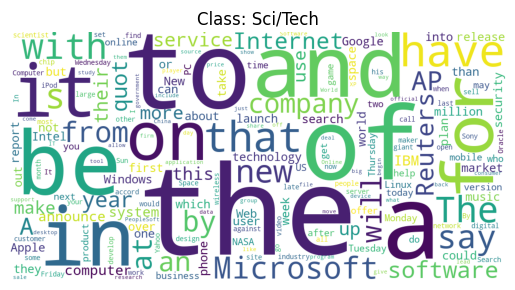

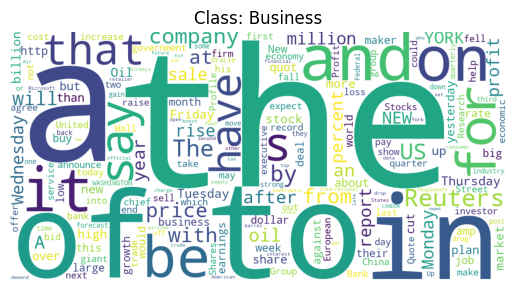

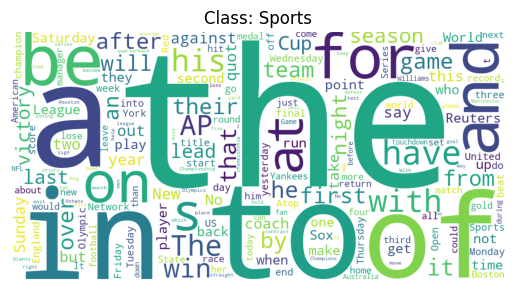

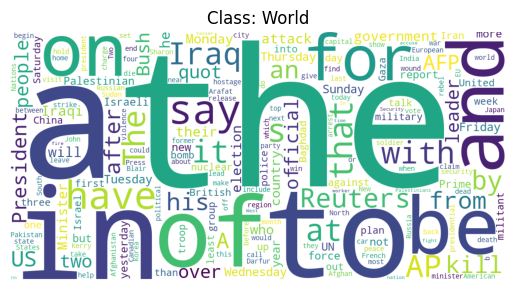

In [12]:
for class_name in answer_class_distributions.keys():
    answer_visualize_word_distribution(answer_class_distributions[class_name], class_name)

Stop words ("the", "a", "of"...) make it difficult to differenciate the words that are characteristic for each class. Let's display the distributions excluding stop words:

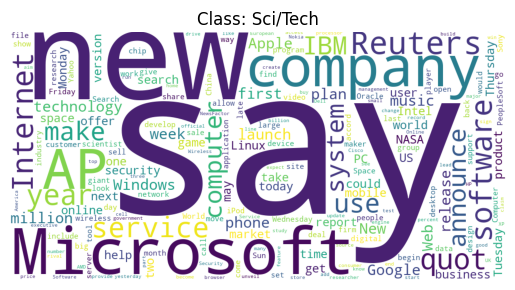

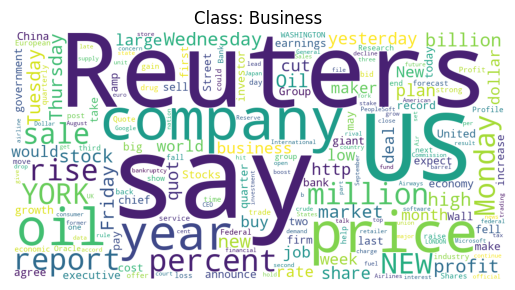

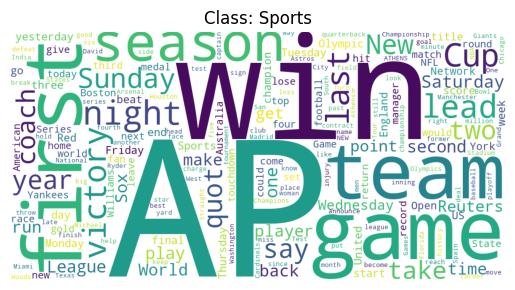

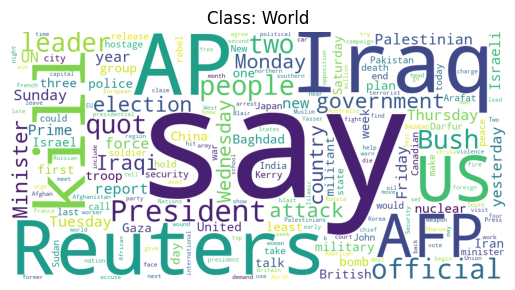

In [13]:
answer_df = answer_remove_stopwords(answer_df) 
answer_class_distributions_filtered = answer_get_class_distributions(answer_df)
for class_name in answer_class_distributions_filtered.keys():
    answer_visualize_word_distribution(answer_class_distributions_filtered[class_name], class_name)

We can also get dataframe with a ranking of the most used words per class. To do so, sort the dataframe with the word distribution for a class in descending order on the `count` column and take the first `n_words` elements.
- Hint: use the `pandas.DataFrame.sort_values` function for sorting a dataframe.
- Hint: use the `pandas.DataFrame.head` functions to get the first `n_words` rows per class. Set `n_words=5` by default if the parameter is not provided.

In [14]:
print("Top-10 most used words in class \"Business\" (dataset with stop words):")
display(answer_most_used_words(answer_class_distributions["Business"], n_words=10))
print("Top-10 most used words in class \"Business\" (dataset without stop words):")
display(answer_most_used_words(answer_class_distributions_filtered["Business"], n_words=10))

Top-10 most used words in class "Business" (dataset with stop words):


,class,tokens,count
28111,Business,the,37998
17122,Business,a,30841
28259,Business,to,29384
24422,Business,of,22539
22506,Business,in,21446
17528,Business,and,16889
24467,Business,on,16180
22945,Business,it,15196
18021,Business,be,13079
21417,Business,for,11746


Top-10 most used words in class "Business" (dataset without stop words):


,class,tokens,count
26317,Business,say,8879
12756,Business,Reuters,6893
15719,Business,US,5609
18895,Business,company,5062
25086,Business,price,4611
24181,Business,oil,3731
29133,Business,year,3375
24627,Business,percent,3084
25887,Business,report,2853
23619,Business,million,2774


In [15]:
def tokenize_and_lemmatize(df):
    """
    Tokenize and lemmatize the text in the dataset.

    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe containing at least the text column.

    Returns
    -------
    pandas.DataFrame
        The dataframe with the added tokens column.
    """
    ###################################
    # Fill in your answer here
    return None
    ###################################


def get_class_distributions(df, token_col="tokens"):
    """
    Generate dataframes with the word distribution for each class in the data.

    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe containing at least the "class" and "tokens" columns.
    token_col: str
        Name of the column that stores the tokens.

    Returns
    -------
    dict:
        Dictionary where keys are the class names and values are dataframes with the word distribution
        of each class (the "count" column should have the number of appearances of each word in that class).
    """
    ###################################
    # Fill in your answer here
    return None
    ###################################


def visualize_word_distribution(df, class_name):
    """
    Displays a word cloud given a word distribution.

    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe containing at least the tokens and counts columns with the word distribution in a class.
    class_name: str
        Name of the class.
    """
    ###################################
    # Fill in your answer here
    pass
    ###################################


def most_used_words(df, n_words=5):
    """
    Generate a dataframe with the n_words most used words per class, and their count.

    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe containing at least the class and tokens columns.
    n_words: int
        Number of most used words to include in the dataframe.
    Returns
    -------
    pandas.DataFrame
        The dataframe with n_words rows per class, and an added 'count' column.
        The dataframe is sorted in descending order on the count.
    """
    ###################################
    # Fill in your answer here
    return None
    ###################################


def remove_stopwords(df):
    """
    Remove stopwords from the tokens.

    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe containing at least the tokens column,
        where the value in each row is a list of tokens.

    Returns
    -------
    pandas.DataFrame
        The dataframe with stopwords removed from the tokens column.
    """
    ###################################
    # Fill in your answer here
    return None
    ###################################

# Edit this.
df_train = None  # Tokenize, lemmatize and remove stop words
class_distributions = None # Get dictionary of class distributions
most_used_words_business = None # Get top 5 words for the "Business" class

The code below tests if all your functions combined match the expected output.

In [16]:
# Check ataframe after tokenizing, lemmatizing and removing stop words
check_answer_df(df_train, answer_df)

Test case 1 failed.
Your output is:


None

Expected output is:


,class_idx,class,text,tokens
0,3,Business,Wall St. Bears Claw Back Into the Black (Reute...,"[Wall, St., Bears, Claw, Back, Black, (, Reute..."
1,3,Business,Carlyle Looks Toward Commercial Aerospace (Reu...,"[Carlyle, Looks, Toward, Commercial, Aerospace..."
2,3,Business,Oil and Economy Cloud Stocks' Outlook (Reuters...,"[Oil, Economy, Cloud, Stocks, ', Outlook, (, R..."
3,3,Business,Iraq Halts Oil Exports from Main Southern Pipe...,"[Iraq, Halts, Oil, Exports, Main, Southern, Pi..."
4,3,Business,"Oil prices soar to all-time record, posing new...","[Oil, price, soar, all-time, record, ,, pose, ..."
...,...,...,...,...
119995,1,World,Pakistan's Musharraf Says Won't Quit as Army C...,"[Pakistan, 's, Musharraf, Says, Wo, n't, Quit,..."
119996,2,Sports,Renteria signing a top-shelf deal Red Sox gene...,"[Renteria, sign, top-shelf, deal, Red, Sox, ge..."
119997,2,Sports,Saban not going to Dolphins yet The Miami Dolp...,"[Saban, go, Dolphins, yet, Miami, Dolphins, pu..."
119998,2,Sports,Today's NFL games PITTSBURGH at NY GIANTS Time...,"[Today, 's, NFL, game, PITTSBURGH, NY, GIANTS,..."


In [17]:
# Check class distributions (we check only the class Business)
if class_distributions is not None:
    check_answer_df(class_distributions["Business"], answer_class_distributions_filtered["Business"])
    print("Student\'s plot:")
    visualize_word_distribution(class_distributions["Business"], "Business")
    print("Answer plot:")
    visualize_word_distribution(answer_class_distributions_filtered["Business"], "Business")

In [18]:
# Check most used words
check_answer_df(most_used_words_business, answer_most_used_words(answer_class_distributions_filtered["Business"]))

Test case 1 failed.
Your output is:


None

Expected output is:


,class,tokens,count
26317,Business,say,8879
12756,Business,Reuters,6893
15719,Business,US,5609
18895,Business,company,5062
25086,Business,price,4611


## Task 4: Another option: spaCy

spaCy is another library used to perform various NLP tasks like tokenization, part-of-speech tagging, named entity recognition, dependency parsing, and much more. It provides pre-trained models for different languages and domains, which can be used as-is but also can be fine-tuned on a specific task or domain.

In an object-oriented way, spaCy can be thought of as a collection of classes and objects that work together to perform NLP tasks. Some of the important functions and classes in spaCy include:

- `nlp`: The core function that provides the main functionality of spaCy. It is used to process text and create a `Doc` object.
- [`Doc`](https://spacy.io/api/doc): A container for accessing linguistic annotations like tokens, part-of-speech tags, named entities, and dependency parse information. It is created by the `nlp` function and represents a processed document.
- [`Token`](https://spacy.io/api/token): An object representing a single token in a `Doc` object. It contains information like the token text, part-of-speech tag, lemma, embedding, and much more.

When a text is processed by spaCy, it is first passed to the `nlp` function, which uses the loaded model to tokenize the text and applies various linguistic annotations like part-of-speech tagging, named entity recognition, and dependency parsing in the background. The resulting annotations are stored in a `Doc` object, which can be accessed and manipulated using various methods and attributes. For example, the `Doc` object can be iterated over to access each `Token` object in the document.

In [19]:
# Load the small English model in spaCy.
# Disable Named Entity Recognition and the parser in the model pipeline since we're not using it.
# Check the following website for the spaCy NLP pipeline:
# - https://spacy.io/usage/processing-pipelines
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Process the text using spaCy.
doc = nlp(text)

# This becomes a spaCy Doc object, which prints nicely as the original string.
print(type(doc), doc)

# We can iterate over the tokens in the Doc, since it has already been tokenized underneath.
print(type(doc[0]))
for token in doc:
    print(token)

<class 'spacy.tokens.doc.Doc'> The quick brown fox jumped over the lazy dog. The cats couldn't wait to sleep all day.
<class 'spacy.tokens.token.Token'>
The
quick
brown
fox
jumped
over
the
lazy
dog
.
The
cats
could
n't
wait
to
sleep
all
day
.


Since a lot of processing has already been done, we can also directly access multiple attributes of the `Token` objects. For example, we can directly access the lemma of the token with `Token.lemma_` and check if a token is a stop word with `Token.is_stop`.

In [20]:
print(doc[0].lemma_, type(doc[0].lemma_), doc[0].is_stop, type(doc[0].is_stop))

the <class 'str'> True <class 'bool'>


Here is the code to add a column with a `Doc` representation of the `text` column to the dataframe. Executing this cell takes several minutes, so we added a progress bar.

In [21]:
def add_spacy(df):
    """
    Add a column with the spaCy Doc objects.

    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe containing at least the text column.

    Returns
    -------
    pandas.DataFrame
        The dataframe with the added doc column.
    """
    # Copy the dataframe to avoid editing the original one.
    df = df.copy(deep=True)

    # Get the number of CPUs in the machine.
    n_process = max(1, os.cpu_count()-2)

    # Use multiple CPUs to speed up computing.
    df["doc"] = [doc for doc in tqdm(nlp.pipe(df["text"], n_process=n_process), total=df.shape[0])]

    return df


df_train = add_spacy(answer_df)
display(df_train)

  0%|          | 0/120000 [00:00<?, ?it/s]

Process Process-2:
Process Process-7:
Process Process-1:
Process Process-3:
Process Process-4:
Process Process-5:
Process Process-6:
Process Process-8:
Traceback (most recent call last):
  File "/Users/mon/teaching/DS/modules/text-data-module/.conda/lib/python3.11/site-packages/spacy/language.py", line 2354, in _apply_pipes
    docs = (
           ^
TypeError: '_WorkDoneSentinel' object is not iterable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/mon/teaching/DS/modules/text-data-module/.conda/lib/python3.11/site-packages/spacy/language.py", line 2354, in _apply_pipes
    docs = (
           ^
TypeError: '_WorkDoneSentinel' object is not iterable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/mon/teaching/DS/modules/text-data-module/.conda/lib/python3.11/site-packages/spa

,class_idx,class,text,tokens,doc
0,3,Business,Wall St. Bears Claw Back Into the Black (Reute...,"[Wall, St., Bears, Claw, Back, Black, (, Reute...","(Wall, St., Bears, Claw, Back, Into, the, Blac..."
1,3,Business,Carlyle Looks Toward Commercial Aerospace (Reu...,"[Carlyle, Looks, Toward, Commercial, Aerospace...","(Carlyle, Looks, Toward, Commercial, Aerospace..."
2,3,Business,Oil and Economy Cloud Stocks' Outlook (Reuters...,"[Oil, Economy, Cloud, Stocks, ', Outlook, (, R...","(Oil, and, Economy, Cloud, Stocks, ', Outlook,..."
3,3,Business,Iraq Halts Oil Exports from Main Southern Pipe...,"[Iraq, Halts, Oil, Exports, Main, Southern, Pi...","(Iraq, Halts, Oil, Exports, from, Main, Southe..."
4,3,Business,"Oil prices soar to all-time record, posing new...","[Oil, price, soar, all-time, record, ,, pose, ...","(Oil, prices, soar, to, all, -, time, record, ..."
...,...,...,...,...,...
119995,1,World,Pakistan's Musharraf Says Won't Quit as Army C...,"[Pakistan, 's, Musharraf, Says, Wo, n't, Quit,...","(Pakistan, 's, Musharraf, Says, Wo, n't, Quit,..."
119996,2,Sports,Renteria signing a top-shelf deal Red Sox gene...,"[Renteria, sign, top-shelf, deal, Red, Sox, ge...","(Renteria, signing, a, top, -, shelf, deal, Re..."
119997,2,Sports,Saban not going to Dolphins yet The Miami Dolp...,"[Saban, go, Dolphins, yet, Miami, Dolphins, pu...","(Saban, not, going, to, Dolphins, yet, The, Mi..."
119998,2,Sports,Today's NFL games PITTSBURGH at NY GIANTS Time...,"[Today, 's, NFL, game, PITTSBURGH, NY, GIANTS,...","(Today, 's, NFL, games, PITTSBURGH, at, NY, GI..."


<a name="a4"></a>

### Assignment for Task 4

**Your task (which is your assignment) is to write a function to do the following:**
- Add a `spacy_tokens` column to the `df_train` dataframe containing a list of lemmatized tokens as strings. 
    - Hint: use a `pandas.Series.apply` operation on the `doc` column to accomplish this.
    
    Our goal is to have a dataframe that looks like the following:

In [22]:
answer_df = answer_spacy_tokens(df_train)
display(answer_df)

,class_idx,class,text,tokens,doc,spacy_tokens
0,3,Business,Wall St. Bears Claw Back Into the Black (Reute...,"[Wall, St., Bears, Claw, Back, Black, (, Reute...","(Wall, St., Bears, Claw, Back, Into, the, Blac...","[Wall, St., Bears, Claw, Black, (, Reuters, ),..."
1,3,Business,Carlyle Looks Toward Commercial Aerospace (Reu...,"[Carlyle, Looks, Toward, Commercial, Aerospace...","(Carlyle, Looks, Toward, Commercial, Aerospace...","[Carlyle, look, Commercial, Aerospace, (, Reut..."
2,3,Business,Oil and Economy Cloud Stocks' Outlook (Reuters...,"[Oil, Economy, Cloud, Stocks, ', Outlook, (, R...","(Oil, and, Economy, Cloud, Stocks, ', Outlook,...","[oil, Economy, Cloud, Stocks, ', Outlook, (, R..."
3,3,Business,Iraq Halts Oil Exports from Main Southern Pipe...,"[Iraq, Halts, Oil, Exports, Main, Southern, Pi...","(Iraq, Halts, Oil, Exports, from, Main, Southe...","[Iraq, Halts, Oil, Exports, Main, Southern, Pi..."
4,3,Business,"Oil prices soar to all-time record, posing new...","[Oil, price, soar, all-time, record, ,, pose, ...","(Oil, prices, soar, to, all, -, time, record, ...","[oil, price, soar, -, time, record, ,, pose, n..."
...,...,...,...,...,...,...
119995,1,World,Pakistan's Musharraf Says Won't Quit as Army C...,"[Pakistan, 's, Musharraf, Says, Wo, n't, Quit,...","(Pakistan, 's, Musharraf, Says, Wo, n't, Quit,...","[Pakistan, Musharraf, say, will, Quit, Army, C..."
119996,2,Sports,Renteria signing a top-shelf deal Red Sox gene...,"[Renteria, sign, top-shelf, deal, Red, Sox, ge...","(Renteria, signing, a, top, -, shelf, deal, Re...","[Renteria, sign, -, shelf, deal, Red, Sox, gen..."
119997,2,Sports,Saban not going to Dolphins yet The Miami Dolp...,"[Saban, go, Dolphins, yet, Miami, Dolphins, pu...","(Saban, not, going, to, Dolphins, yet, The, Mi...","[saban, go, Dolphins, Miami, Dolphins, courtsh..."
119998,2,Sports,Today's NFL games PITTSBURGH at NY GIANTS Time...,"[Today, 's, NFL, game, PITTSBURGH, NY, GIANTS,...","(Today, 's, NFL, games, PITTSBURGH, at, NY, GI...","[today, NFL, game, pittsburgh, NY, giant, time..."


In [23]:
def spacy_tokens(df):
    """
    Add a column with a list of lemmatized tokens, without stopwords.

    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe containing at least the doc column.

    Returns
    -------
    pandas.DataFrame
        The dataframe with the spacy_tokens column.
    """
    ###################################
    # Fill in your answer here
    return None
    ###################################


df_train = df_train  # Edit this.

The code below tests if the function matches the expected output.

In [24]:
check_answer_df(df_train, answer_df)

Test case 1 failed.
Your output is:


,class_idx,class,text,tokens,doc
0,3,Business,Wall St. Bears Claw Back Into the Black (Reute...,"[Wall, St., Bears, Claw, Back, Black, (, Reute...","(Wall, St., Bears, Claw, Back, Into, the, Blac..."
1,3,Business,Carlyle Looks Toward Commercial Aerospace (Reu...,"[Carlyle, Looks, Toward, Commercial, Aerospace...","(Carlyle, Looks, Toward, Commercial, Aerospace..."
2,3,Business,Oil and Economy Cloud Stocks' Outlook (Reuters...,"[Oil, Economy, Cloud, Stocks, ', Outlook, (, R...","(Oil, and, Economy, Cloud, Stocks, ', Outlook,..."
3,3,Business,Iraq Halts Oil Exports from Main Southern Pipe...,"[Iraq, Halts, Oil, Exports, Main, Southern, Pi...","(Iraq, Halts, Oil, Exports, from, Main, Southe..."
4,3,Business,"Oil prices soar to all-time record, posing new...","[Oil, price, soar, all-time, record, ,, pose, ...","(Oil, prices, soar, to, all, -, time, record, ..."
...,...,...,...,...,...
119995,1,World,Pakistan's Musharraf Says Won't Quit as Army C...,"[Pakistan, 's, Musharraf, Says, Wo, n't, Quit,...","(Pakistan, 's, Musharraf, Says, Wo, n't, Quit,..."
119996,2,Sports,Renteria signing a top-shelf deal Red Sox gene...,"[Renteria, sign, top-shelf, deal, Red, Sox, ge...","(Renteria, signing, a, top, -, shelf, deal, Re..."
119997,2,Sports,Saban not going to Dolphins yet The Miami Dolp...,"[Saban, go, Dolphins, yet, Miami, Dolphins, pu...","(Saban, not, going, to, Dolphins, yet, The, Mi..."
119998,2,Sports,Today's NFL games PITTSBURGH at NY GIANTS Time...,"[Today, 's, NFL, game, PITTSBURGH, NY, GIANTS,...","(Today, 's, NFL, games, PITTSBURGH, at, NY, GI..."


Expected output is:


,class_idx,class,text,tokens,doc,spacy_tokens
0,3,Business,Wall St. Bears Claw Back Into the Black (Reute...,"[Wall, St., Bears, Claw, Back, Black, (, Reute...","(Wall, St., Bears, Claw, Back, Into, the, Blac...","[Wall, St., Bears, Claw, Black, (, Reuters, ),..."
1,3,Business,Carlyle Looks Toward Commercial Aerospace (Reu...,"[Carlyle, Looks, Toward, Commercial, Aerospace...","(Carlyle, Looks, Toward, Commercial, Aerospace...","[Carlyle, look, Commercial, Aerospace, (, Reut..."
2,3,Business,Oil and Economy Cloud Stocks' Outlook (Reuters...,"[Oil, Economy, Cloud, Stocks, ', Outlook, (, R...","(Oil, and, Economy, Cloud, Stocks, ', Outlook,...","[oil, Economy, Cloud, Stocks, ', Outlook, (, R..."
3,3,Business,Iraq Halts Oil Exports from Main Southern Pipe...,"[Iraq, Halts, Oil, Exports, Main, Southern, Pi...","(Iraq, Halts, Oil, Exports, from, Main, Southe...","[Iraq, Halts, Oil, Exports, Main, Southern, Pi..."
4,3,Business,"Oil prices soar to all-time record, posing new...","[Oil, price, soar, all-time, record, ,, pose, ...","(Oil, prices, soar, to, all, -, time, record, ...","[oil, price, soar, -, time, record, ,, pose, n..."
...,...,...,...,...,...,...
119995,1,World,Pakistan's Musharraf Says Won't Quit as Army C...,"[Pakistan, 's, Musharraf, Says, Wo, n't, Quit,...","(Pakistan, 's, Musharraf, Says, Wo, n't, Quit,...","[Pakistan, Musharraf, say, will, Quit, Army, C..."
119996,2,Sports,Renteria signing a top-shelf deal Red Sox gene...,"[Renteria, sign, top-shelf, deal, Red, Sox, ge...","(Renteria, signing, a, top, -, shelf, deal, Re...","[Renteria, sign, -, shelf, deal, Red, Sox, gen..."
119997,2,Sports,Saban not going to Dolphins yet The Miami Dolp...,"[Saban, go, Dolphins, yet, Miami, Dolphins, pu...","(Saban, not, going, to, Dolphins, yet, The, Mi...","[saban, go, Dolphins, Miami, Dolphins, courtsh..."
119998,2,Sports,Today's NFL games PITTSBURGH at NY GIANTS Time...,"[Today, 's, NFL, game, PITTSBURGH, NY, GIANTS,...","(Today, 's, NFL, games, PITTSBURGH, at, NY, GI...","[today, NFL, game, pittsburgh, NY, giant, time..."


We use the answer version of the `most_used_words` function to again display the top 5 words per class in the dataset. Do you see some differences between the lemmatized tokens obtained from NLTK and spaCy?

In [25]:
answer_class_distributions = answer_get_class_distributions(answer_df, "spacy_tokens")
display(answer_most_used_words(answer_class_distributions["Business"]))

,class,spacy_tokens,count
24978,Business,say,8926
11350,Business,Reuters,6882
22766,Business,oil,5226
17100,Business,company,5160
23743,Business,price,5051


<a name="t5"></a>

## Task 5: Unsupervised Learning - Topic Modelling

Topic modelling is a technique used in NLP that aims to identify the underlying topics or themes in a collection of texts. One way to perform topic modelling is using the probabilistic model Latent Dirichlet Allocation (LDA).

LDA assumes that each document in a collection is a mixture of different topics, and each topic is a probability distribution over a set of words. The model then infers the underlying topic distribution for each document in the collection and the word distribution for each topic. LDA is trained using an iterative algorithm that maximizes the likelihood of observing the given documents.

To use LDA, we need to represent the documents as a bag of words, where the order of the words is ignored and only the frequency of each word in the document is considered. This bag-of-words representation allows us to represent each document as a vector of word frequencies, which can be used as input to the LDA algorithm. Computing LDA might take a moment on our dataset size.

In [27]:
# Define the number of topics to model with LDA.
num_topics = 4

# Convert preprocessed text to bag-of-words representation using CountVectorizer.
vectorizer = CountVectorizer(max_features=50000)

# fit_transform requires either a string as input or multiple extra arguments
# and functions, so we simply turn the tokens into string.
X = vectorizer.fit_transform(answer_df["spacy_tokens"].apply(lambda x: " ".join(x)).values)

# Fit LDA to the feature matrix. Verbose so we know what iteration we're on.
lda = LatentDirichletAllocation(n_components=num_topics, max_iter=10, random_state=42, verbose=True)
lda.fit(X)

# Extract the topic proportions for each document.
doc_topic_proportions = lda.transform(X)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


Using this function, we can take a look at the most important words per topic. Do you see some similarities with the most occurring words per class after stopword removal?

In [28]:
def n_top_wordlist(model, features, ntopwords=5):
    """
    Get the 5 most important words per LDA topic.
    """
    output = {}
    for topic_idx, topic in enumerate(model.components_):
        output[topic_idx] = [features[i] for i in topic.argsort()[:-ntopwords - 1:-1]]
    return output


# Get the words from the CountVectorizer.
tf_feature_names = vectorizer.get_feature_names_out()

display(n_top_wordlist(lda, tf_feature_names))

{0: ['39', 'win', 'ap', 'game', 'team'],
 1: ['say', '39', 'ap', 'iraq', 'president'],
 2: ['reuters', 'oil', 'stock', 'price', 'say'],
 3: ['39', 'new', 'company', 'say', 'microsoft']}

<a name="t5-1"></a>

### Evaluation

Adjusted Mutual Information (AMI) and Adjusted Rand Index (ARI) are two metrics used to evaluate the performance of clustering algorithms.

AMI is a measure that takes into account the possibility of two random clusters appearing to be similar. It is calculated as the difference between the Mutual Information (MI) of two clusterings and the expected MI, divided by the average entropy of the two clusterings minus the expected MI. AMI ranges between 0 and 1, where 0 indicates no agreement between the two clusterings and 1 indicates identical clusterings.

The Rand Index (RI) is a measure that counts the number of pairs of samples that are assigned to the same or different clusters in both the predicted and true clusterings. The raw RI score is then adjusted for chance into the ARI score using a scheme similar to that of AMI. For ARI a score of 0 indicates random labeling and 1 indicates perfect agreement. The ARI is bounded below by -0.5 for very large differences in labeling.

<a name="a5"></a>

### Assignment for Task 5

**Your task (which is your assignment) is to write a function to do the following:**
- The `doc_topic_proportions` contains the proportions of how much that document belongs to every topic. For every document, get the topic in which it has the largest proportion. Afterwards, look at the AMI and ARI scores. Can you improve the scores by modelling more topics, using a different set of tokens, or using more epochs?
    - Hint: use the `numpy.argmax` function.
    
    Our goal is to get an array that looks like the following:

In [29]:
answer_topic_most = answer_largest_proportion(doc_topic_proportions)
print(answer_topic_most, answer_topic_most.shape)

[2 3 2 ... 0 0 0] (120000,)


In [30]:
def largest_proportion(arr):
    """
    For every row, get the column number where it has the largest value.

    Parameters
    ----------
    arr : numpy.array
        The array with the amount of topics as the amount of columns
        and the amount of documents as the number of rows.
        Every row should sum up to 1.

    Returns
    -------
    numpy.array
        The 1-dimensional array containing the label of the topic
        the document has the largest proportion in.
    """
    ###################################
    # Fill in your answer here
    return None
    ###################################

The code below tests if the function matches the expected output.

In [31]:
topic_most = largest_proportion(doc_topic_proportions)

check_answer_np(topic_most, answer_topic_most)

Test case 1 failed.
Your output is:
None
Expected output is:
[2 3 2 ... 0 0 0]


In [32]:
ami_score = adjusted_mutual_info_score(df_train["class"], answer_topic_most)
ari_score = adjusted_rand_score(df_train["class"], answer_topic_most)

print(f"Adjusted mutual information score: {ami_score:.2f}")
print(f"Adjusted rand score: {ari_score:.2f}")

Adjusted mutual information score: 0.46
Adjusted rand score: 0.45


Do some topics get (way) more documents assigned to them than others? Let's take a look.

In [33]:
unique, counts = np.unique(answer_topic_most, return_counts=True)

print(dict(zip(unique, counts)))

{0: 34524, 1: 33806, 2: 19254, 3: 32416}


<a name="t6"></a>

## Task 6: Word Embeddings

Word embeddings represent words as vectors in a high-dimensional space. The key idea behind word embeddings is that words with similar meanings tend to appear in similar contexts, and therefore their vector representations should be close together in this high-dimensional space. Word embeddings have been widely used in various NLP tasks such as sentiment analysis, machine translation, and information retrieval.

There are several techniques to generate word embeddings, but one of the most popular methods is the Word2Vec algorithm, which is based on a neural network architecture. Word2Vec learns embeddings by predicting the probability of a word given its context (continuous bag of words or skip-gram model). The output of the network is a set of word vectors that can be used as embeddings.

We can train a Word2Vec model ourselves, but keep in mind that later on, it's not nice if we don't have embeddings for certain words in the test set. So let's first apply the familiar preprocessing steps to the test set:

In [34]:
# Reformat df_test.
df_test = reformat_data(df_test)

# NLTK preprocessing.
df_test = answer_remove_stopwords(answer_tokenize_and_lemmatize(df_test))

# spaCy preprocessing.
df_test = answer_spacy_tokens(add_spacy(df_test))

display(df_test)

  0%|          | 0/7600 [00:00<?, ?it/s]

  0%|          | 0/7600 [00:00<?, ?it/s]

  0%|          | 0/7600 [00:00<?, ?it/s]

Process Process-9:
Process Process-14:
Process Process-12:
Process Process-11:
Process Process-10:
Traceback (most recent call last):
  File "/Users/mon/teaching/DS/modules/text-data-module/.conda/lib/python3.11/site-packages/spacy/language.py", line 2354, in _apply_pipes
    docs = (
           ^
TypeError: '_WorkDoneSentinel' object is not iterable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/mon/teaching/DS/modules/text-data-module/.conda/lib/python3.11/site-packages/spacy/language.py", line 2354, in _apply_pipes
    docs = (
           ^
TypeError: '_WorkDoneSentinel' object is not iterable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
Process Process-15:
Traceback (most recent call last):
  File "/Users/mon/teaching/DS/modules/text-data-module/.conda/lib/python3.11/site-packages/spacy/language.py", line 2354, in _a

,class_idx,class,text,tokens,doc,spacy_tokens
0,3,Business,Fears for T N pension after talks Unions repre...,"[Fears, N, pension, talk, Unions, represent, w...","(Fears, for, T, N, pension, after, talks, Unio...","[fear, T, N, pension, talk, Unions, represent,..."
1,4,Sci/Tech,The Race is On: Second Private Team Sets Launc...,"[Race, :, Second, Private, Team, Sets, Launch,...","(The, Race, is, On, :, Second, Private, Team, ...","[Race, :, second, private, team, set, Launch, ..."
2,4,Sci/Tech,Ky. Company Wins Grant to Study Peptides (AP) ...,"[Ky., Company, Wins, Grant, Study, Peptides, (...","(Ky., Company, Wins, Grant, to, Study, Peptide...","[Ky., Company, win, Grant, study, Peptides, (,..."
3,4,Sci/Tech,Prediction Unit Helps Forecast Wildfires (AP) ...,"[Prediction, Unit, Helps, Forecast, Wildfires,...","(Prediction, Unit, Helps, Forecast, Wildfires,...","[prediction, Unit, help, Forecast, Wildfires, ..."
4,4,Sci/Tech,Calif. Aims to Limit Farm-Related Smog (AP) AP...,"[Calif, ., Aims, Limit, Farm-Related, Smog, (,...","(Calif., Aims, to, Limit, Farm, -, Related, Sm...","[Calif., aim, limit, Farm, -, Related, Smog, (..."
...,...,...,...,...,...,...
7595,1,World,Around the world Ukrainian presidential candid...,"[Around, world, Ukrainian, presidential, candi...","(Around, the, world, Ukrainian, presidential, ...","[world, ukrainian, presidential, candidate, Vi..."
7596,2,Sports,Void is filled with Clement With the supply of...,"[Void, fill, Clement, supply, attractive, pitc...","(Void, is, filled, with, Clement, With, the, s...","[Void, fill, Clement, supply, attractive, pitc..."
7597,2,Sports,Martinez leaves bitter Like Roger Clemens did ...,"[Martinez, leave, bitter, Like, Roger, Clemens...","(Martinez, leaves, bitter, Like, Roger, Clemen...","[Martinez, leave, bitter, like, Roger, Clemens..."
7598,3,Business,5 of arthritis patients in Singapore take Bext...,"[5, arthritis, patient, Singapore, take, Bextr...","(5, of, arthritis, patients, in, Singapore, ta...","[5, arthritis, patient, Singapore, Bextra, Cel..."


To obtain the complete model, we combine the `tokens` column into one series and call the `Word2Vec` function.

In [35]:
# Get all tokens into one series.
tokens_both = pd.concat([df_train["tokens"], df_test["tokens"]])

# Train a Word2Vec model on the NLTK tokens.
w2v_model = Word2Vec(tokens_both.values, vector_size=96, min_count=1)

To obtain the embeddings, we can use the `Word2Vec.wv[word]` syntax. To get multiple vectors nicely next to each other in a 2D matrix, we can call `numpy.vstack`.

In [36]:
print(np.vstack([w2v_model.wv[word] for word in ["rain", "cat", "dog"]]))

[[-7.14723289e-01 -9.85410631e-01  1.28214478e-01  1.36203253e+00
  -1.40532684e+00  2.30665636e+00  2.66024191e-02 -9.73389924e-01
   9.34059769e-02  1.47872875e-02 -9.61144507e-01  1.61239819e-04
  -2.57491052e-01 -1.02184308e+00  1.87264025e+00  1.43110681e+00
   7.26401210e-01  2.85117049e-02  1.65555632e+00  1.41082823e+00
   1.26697898e+00  3.21282655e-01 -2.48096919e+00 -2.11051488e+00
   3.36927474e-01 -1.39456975e+00  6.61244214e-01  2.35158280e-01
   4.68296230e-01 -4.22622025e-01  8.24491978e-01 -1.26068664e+00
   7.05022693e-01 -2.60038614e-01 -2.36044955e+00 -7.98931047e-02
   4.56908531e-02  6.06510878e-01 -1.99003553e+00 -1.50310203e-01
   9.34418797e-01  1.13756859e+00 -9.47219968e-01  3.90803844e-01
   8.01925361e-01 -2.27431461e-01 -1.50044531e-01  2.83845752e-01
  -1.34637463e+00  3.45673144e-01  3.55474740e-01 -3.60177644e-02
   5.82462311e-01  1.00663173e+00  1.49305594e+00 -9.84133929e-02
  -1.28827918e+00  1.51080716e+00 -8.53368819e-01  1.99422777e+00
   1.39757

The spaCy model we used has a `Tok2Vec` algorithm in its pipeline, so we can directly access the 2D matrix of all word vectors on a document with the `Doc.tensor` attribute. Keep in mind this still contains the embeddings of the stopwords.

In [37]:
print(doc.tensor)

[[ 0.8194096  -0.32325384  0.629434   ... -0.4773795  -0.75188184
   0.0357812 ]
 [ 0.81603235 -1.2405076   0.9558864  ...  0.52738035 -1.0743449
  -0.30024663]
 [ 1.1372288  -1.0574455  -0.20238371 ...  0.38068694 -0.03450352
   0.540362  ]
 ...
 [ 1.2355547  -0.6400209  -0.59921527 ... -0.12730186 -0.3426052
  -1.1101209 ]
 [ 0.19090153 -0.6523549  -0.4373727  ...  0.8468437   0.49040866
  -0.14062503]
 [-0.5942377  -0.93374133  0.54625034 ... -0.05576921 -0.9447482
  -1.1440233 ]]


<a name="a6"></a>

### Assignment for Task 6

**Your task (which is your assignment) is to write a function to do the following:**

- First, sample 10% of the data from both datasets, we're not going to be using all the data for the neural network.
    - Hint: use the `pandas.DataFrame.sample` function to sample a fraction of the data. Specify a `random_state` value to always get the same rows from the dataframe.
- Add a `tensor` column to both the test and train dataframes, the column should hold one array per row, containing all the word embedding vectors as columns. You can choose whether to use vectors from our new model or the ones from spaCy.
- Determine the largest amount of columns in the `tensor` column, between both datasets.
    - Hint: use the `numpy.ndarray.shape` attribute to see the dimensions of an array. 
    - Hint: use the `pd.Series.max` function to determine the largest item in a series.
- Pad all arrays in the `tensor` column to be equal in size to the biggest tensor, by adding columns of zeroes at the end. This way all inputs for a neural network have the same size.
    - Hint: use the `numpy.pad` function to pad an array.
    
    After the function, our `df_train` could look like the following:

In [38]:
answer_df_train, answer_df_test = answer_add_padded_tensors(answer_df, df_test)
display(answer_df_train)

,class_idx,class,text,tokens,doc,spacy_tokens,tensor
71787,3,Business,"BBC set for major shake-up, claims newspaper L...","[BBC, set, major, shake-up, ,, claim, newspape...","(BBC, set, for, major, shake, -, up, ,, claims...","[BBC, set, major, shake, -, ,, claim, newspape...","[[-1.2082729, -0.3078657, -0.024013683, 0.8767..."
67218,3,Business,Marsh averts cash crunch Embattled insurance b...,"[Marsh, avert, cash, crunch, Embattled, insura...","(Marsh, averts, cash, crunch, Embattled, insur...","[Marsh, avert, cash, crunch, embattle, insuran...","[[-0.5161524, -1.0432737, 0.41055828, 0.692814..."
54066,2,Sports,"Jeter, Yankees Look to Take Control (AP) AP - ...","[Jeter, ,, Yankees, Look, Take, Control, (, AP...","(Jeter, ,, Yankees, Look, to, Take, Control, (...","[Jeter, ,, Yankees, look, Control, (, AP, ), A...","[[-1.8953018, 0.86324644, 0.094712, 0.8372249,..."
7168,4,Sci/Tech,Flying the Sun to Safety When the Genesis caps...,"[Flying, Sun, Safety, Genesis, capsule, come, ...","(Flying, the, Sun, to, Safety, When, the, Gene...","[fly, Sun, Safety, Genesis, capsule, come, Ear...","[[-1.7130511, 0.37374157, 0.010348439, 0.47499..."
29618,3,Business,Stocks Seen Flat as Nortel and Oil Weigh NEW ...,"[Stocks, Seen, Flat, Nortel, Oil, Weigh, NEW, ...","(Stocks, Seen, Flat, as, Nortel, and, Oil, Wei...","[stock, see, flat, Nortel, Oil, Weigh, , NEW,...","[[-1.336605, 1.0966985, -1.0845684, 1.1307448,..."
...,...,...,...,...,...,...,...
27162,2,Sports,Oakland Athletics Team Report - September 14 (...,"[Oakland, Athletics, Team, Report, -, Septembe...","(Oakland, Athletics, Team, Report, -, Septembe...","[Oakland, Athletics, Team, Report, -, Septembe...","[[0.047526084, -0.40058374, -0.34343717, 0.013..."
82268,4,Sci/Tech,Telcos' convergence strategies diverge CANNES ...,"[Telcos, ', convergence, strategy, diverge, CA...","(Telcos, ', convergence, strategies, diverge, ...","[Telcos, ', convergence, strategy, diverge, CA...","[[-0.87280345, -0.7925482, 0.6395072, 2.060443..."
7765,4,Sci/Tech,Motive aims to head off system glitches Three ...,"[Motive, aim, head, system, glitch, Three, new...","(Motive, aims, to, head, off, system, glitches...","[motive, aim, head, system, glitch, new, softw...","[[-1.2538671, -0.69565564, 0.45192608, 0.78003..."
25871,3,Business,Campbell #39;s 4th-Qtr Net Drops 20 on Higher ...,"[Campbell, #, 39, ;, 4th-Qtr, Net, Drops, 20, ...","(Campbell, #, 39;s, 4th, -, Qtr, Net, Drops, 2...","[campbell, #, 39;s, 4th, -, qtr, Net, Drops, 2...","[[-0.72987264, -0.29359108, -0.6149194, 0.4594..."


In [39]:
def add_padded_tensors(df1, df2):
    """
    First, sample 10% of both datasets and only use that.
    Then, add a tensor column to the dataframes, with every tensor having the same dimensions.

    Parameters
    ----------
    df_train : pandas.DataFrame
        The first dataframe containing at least the tokens or doc column.
    df_test : pandas.DataFrame
        The second dataframe containing at least the tokens or doc column.

    Returns
    -------
    tuple[pandas.DataFrame]
        The sampled dataframes with the added tensor column.
    """
    ###################################
    # Fill in your answer here
    return None
    ###################################


df_train, df_test = df_train, df_test  # Edit this.

The code below tests if the function matches the expected output.

In [40]:
try:
    assert (df_train["tensor"].apply(lambda x: x.shape).unique() ==
            df_test["tensor"].apply(lambda x: x.shape).unique())
    print("Test case 1 passed.")
except Exception:
    print("Test case 1 failed. Not all tensor sizes are equal.")

try:
    assert df_test.shape[0] == 760
    print("Test case 2 passed.")
except Exception:
    print("Test case 2 failed. The test dataframe does not have the correct size.")

Test case 1 failed. Not all tensor sizes are equal.
Test case 2 failed. The test dataframe does not have the correct size.


<a name="t7"></a>

## Task 7: Supervised Learning - Topic Classification

Topic classification is a task in NLP that involves automatically assigning a given text document to one or more predefined categories or topics. This task is essential for various applications, such as document organization, search engines, sentiment analysis, and more.

In recent years, deep learning models have shown remarkable performance in various NLP tasks, including topic classification. We will explore a neural network-based approach for topic classification using the PyTorch framework. PyTorch provides an efficient way to build and train neural networks with a high degree of flexibility and ease of use.

Our neural network will take the embedding representation of the document as input and predict the corresponding topic using a softmax output layer. We will evaluate the performance of our model using various metrics such as accuracy, precision, recall, and F1-score.

The following code demonstrates how to implement a neural network for topic classification in PyTorch. First let's do some more preparations for our inputs, turning them into PyTorch tensors.

In [41]:
# Use dataframes from previous assignment. These use the spaCy tensors.
df_train = answer_df_train
df_test = answer_df_test

# Transform inputs into PyTorch tensors.
input_train = torch.from_numpy(np.stack(df_train["tensor"]))
input_test = torch.from_numpy(np.stack(df_test["tensor"]))

# Get the labels, move to 0-indexed instead of 1-indexed.
train_labels = torch.from_numpy(df_train["class_idx"].values) - 1
test_labels = torch.from_numpy(df_test["class_idx"].values) - 1

# One-hot encode labels for training.
train_target = torch.zeros((len(train_labels), 4))
train_target = train_target.scatter_(1, train_labels.unsqueeze(1), 1).unsqueeze(1)

Then, it's time to define our network. The neural net consists of three fully connected layers (`fc1`, `fc2`, and `fc3`) with ReLU activation (`relu`) in between each layer. We flatten the input tensor using `view` before passing it through the fully connected layers. Finally, we apply the softmax activation function (`softmax`) to the output tensor to obtain the predicted probabilities for each class.

In [42]:
class TopicClassifier(nn.Module):
    def __init__(self, input_width, input_length, output_size):
        super(TopicClassifier, self).__init__()
        self.input_width = input_width
        self.input_length = input_length
        self.output_size = output_size

        self.fc1 = nn.Linear(input_width * input_length, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size)

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Flatten the input tensor.
        x = x.view(-1, self.input_width * self.input_length)

        # Pass through the fully connected layers with ReLU activation.
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)

        # Apply softmax activation to the output.
        x = self.softmax(x)
        return x

Now it's time to train our network, this may take a while, but the current loss will be printed after every epoch.
If you want to run the code faster, you can also put this notebook on Google Colab and use its provided GPU to speed up computing.

In [43]:
# Define parameters.
n_classes = len(train_labels.unique())
input_size = input_train.shape[1:]
num_epochs = 5
lr = 0.001

# Define model, loss function and optimizer.
model = TopicClassifier(*input_size, output_size=n_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# Training loop.
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(zip(input_train, train_target)):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/5], Loss: 1.3392
Epoch [2/5], Loss: 1.1793
Epoch [3/5], Loss: 0.9845
Epoch [4/5], Loss: 0.8884
Epoch [5/5], Loss: 0.8284


<a name="a7"></a>

### Assignment for Task 7 (Optional)

**Your task (which is your assignment) is to do the following:**

- Use the code below to evaluate the neural network. 
- Generate a confusion matrix with `sklearn.metrics.confusion_matrix` (it's already imported so you can call `confusion_matrix`). 
- Plot the confusion matrix using `seaborn.heatmap` (`seaborn` is usually imported as `sns`). Set the `annot` argument to `True` and the `xticklabels` and `yticklabels` to the `labels` list.
- Also, take the time to evaluate the train set. Is there a notable difference in accuracy, precision, recall, and the F1 score between the train and test sets?

In [44]:
# Evaluate the neural net on the test set.
model.eval()

# Sample from the model.
with torch.no_grad():
    test_outputs = model(input_test)
    # Reuse our previous function to get the label with biggest probability.
    test_pred = answer_largest_proportion(test_outputs.detach())

# Set model back to training mode.
model.train()

labels = ["World", "Sports", "Business", "Sci/Tech"]

###################################
# Fill in your answer here
###################################

<a name="a8"></a>

## Optional Assignment / Takeaways

If you do not feel done with text data yet, there's always more to do. You can still experiment with the number of epochs, learning rate, vector size, optimizer, neural network layers, regularization and so much more. Even during the preprocessing, we could have done some things differently, like making everything lowercase and removing punctuation. Be aware that every choice you make along the way trickles down into your pipeline and can have some effect on your results.